In [20]:
from datasets import *
import seaborn as sns
from scipy.special import beta
from scipy.stats import ks_2samp, mannwhitneyu, normaltest, levene, skew, kurtosis
import roblib
from sklearn.decomposition import PCA
from scipy.stats import norm
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

def binarize(x):
    return 2 * (x > np.median(x, 0)) - 1

face_num, feature_num = 4000, 2048

In [41]:
def set_mpl():
    import matplotlib as mpl

    mpl.rcParams['font.size'] = 6
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    mpl.rcParams['font.family'] = 'arial'
    mpl.rcParams['savefig.dpi'] = 480


def plot_start(square=True,figsize=None,ticks_pos=True):
    '''
    unified plot params
    '''
    set_mpl()
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
    elif square:
        fig = plt.figure(figsize=(1.5, 1.5))
    else:
        fig = plt.figure(figsize=(1.5, 0.8))
    ax = fig.add_axes((0.1,0.1,0.8,0.8))
    if ticks_pos:
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
    return fig,ax

In [33]:
norm_mean, norm_cov, sign_keep_ratio = roblib.load(settings.DATAPATH / "vgg_pca2048_genface_par.pkl")
# generate 431050 random normal patterns with matched cov
# np.random.seed(0)
# rand_dataset = np.random.multivariate_normal(
#             norm_mean, np.diag(np.diag(norm_cov)), size=features_ori.shape[0]) #identities.shape[0] # face_num
# rand_dataset_pca = preprocess_pipeline(rand_dataset, [('pca',2048)])
# roblib.dump(rand_dataset_pca,'rand_dataset_pca.pkl')
rand_dataset_pca = roblib.load('rand_dataset_pca.pkl')
face_final_features=roblib.load(settings.DATAPATH / "vgg_pca2048_face.pkl")
print(len(face_final_features))
# continous features
FD_cont = [face_final_features[i][:face_num, :feature_num] for i in range(10)]
np.random.seed(0)
RD1_cont = [np.random.multivariate_normal(
            norm_mean[:feature_num], np.diag(np.diag(norm_cov[:feature_num, :feature_num])), size=face_num) for i in range(10)]
# RD2_cont = rand_dataset_pca[:face_num, :feature_num]

# continous feature correlations
FD_cont_feat_cor = [np.corrcoef(x.T) for x in FD_cont]
RD1_cont_feat_cor = [np.corrcoef(x.T) for x in RD1_cont]
# RD2_cont_feat_cor = np.corrcoef(RD2_cont.T)

# plt.plot(FD_cont.mean(0),label='face')
# plt.plot(RD1_cont.mean(0),label='rand')
# plt.legend()
# plt.xlabel('feature index')
# plt.ylabel('mean')
# print(FD_cont.mean(0),RD1_cont.mean(0))
# print(FD_cont_feat_cor,RD1_cont_feat_cor)

# binary features
FD_binary = [binarize(x) for x in FD_cont]
RD1_binary = [binarize(x) for x in RD1_cont]
# RD2_binary = binarize(RD2_cont)

# binary feature correlations
FD_binary_feat_cor = [np.corrcoef(x.T) for x in FD_binary]
RD1_binary_feat_cor = [np.corrcoef(x.T) for x in RD1_binary]
# RD2_binary_feat_cor = np.corrcoef(RD2_binary.T)


10


In [54]:
# pattern correlation for all features # not used later
# FD_binary_pattern_cor = np.corrcoef(FD_binary)
# RD1_binary_pattern_cor = np.corrcoef(RD1_binary)
# RD2_binary_pattern_cor = np.corrcoef(RD2_binary)
# print(FD_binary.shape,FD_binary_pattern_cor.shape)

def wrap_get_cor(total_fea):
    seed_num = len(FD_binary)
    assert 1<=seed_num<=10
    cor_values = []
    cor0_values = []
    for seed in range(seed_num):
        FD_binary_pattern_cor = np.corrcoef(FD_binary[seed][:, :total_fea])
        RD1_binary_pattern_cor = np.corrcoef(RD1_binary[seed][:, :total_fea])
    #     RD2_binary_pattern_cor = np.corrcoef(RD2_binary[:, :total_fea])
    #     print(FD_binary.shape,FD_binary_pattern_cor.shape)
        N = FD_binary_pattern_cor.shape[0]
        ind = np.triu_indices(N, k = 1)
        cor_values.append(FD_binary_pattern_cor[ind])
        cor0_values.append(RD1_binary_pattern_cor[ind])
#     cor0_control_values = RD2_binary_pattern_cor[ind]
    cor0_control_values = None
    return cor_values, cor0_values, cor0_control_values

def wrap_plot_r_patterns(total_fea):
    cor_values, cor0_values, cor0_control_values = wrap_get_cor(total_fea)
    for metric in ['normal','var','mean_abs','kurt','skew']:
        f = {'normal': lambda x: normaltest(x)[1], 
             'var': np.var,
             'mean_abs': lambda x: np.mean(np.abs(x)),
            'kurt':kurtosis,
             'skew':skew,}[metric]
        print(metric,'face',f(cor_values),'RD-1',f(cor0_values))#,'RD-2',f(cor0_control_values))
    cor_values = np.random.choice(cor_values,size=10000, replace=False)
    cor0_values = np.random.choice(cor0_values,size=10000, replace=False)
#     cor0_control_values = np.random.choice(cor0_control_values,size=10000, replace=False)
    
    r=np.linspace(-0.1,0.1,201)
    # cor_values=np.abs(cor_values)
    # cor0_values=np.abs(cor0_values)
    # r=r[r>=0]
    plt.figure()
#     plt.plot(r, pr_r(r,face_num),'k',label='theoretical r')
    sns.histplot(cor_values,color='b',label='FD',stat="density")
    sns.histplot(cor0_values,color='y',label='RD-1',stat="density")
#     sns.histplot(cor0_control_values,color='g',label='RD-2',stat="density")
    plt.legend()
    plt.xlabel('correlation r between each two patterns')
    plt.title(f'top {total_fea} features')
    plt.show()
    
# wrap_plot_r_patterns(1000)
# wrap_plot_r_patterns(2048)

In [55]:
# binary pattern correlation stats
pattern_r_dt_metric = {}
N_feature_list = np.arange(10,2000,10)
for total_fea in N_feature_list:
    print(total_fea, end=',')
    cor_values, cor0_values, cor0_control_values = wrap_get_cor(total_fea)
    for dt_name, dt in [('FD', cor_values),('RD1',cor0_values)]:#,('RD2',cor0_control_values)]:
        if dt_name not in pattern_r_dt_metric:
            pattern_r_dt_metric[dt_name] = {}
        for metric in ['normal', 'var','mean_abs','kurt','skew']:
            f = {'normal': lambda x: normaltest(x)[1], 
                 'var': np.var,
                 'mean_abs': lambda x: np.mean(np.abs(x)),
                'kurt':kurtosis,
                 'skew':skew,}[metric]
            if metric not in pattern_r_dt_metric[dt_name]:
                pattern_r_dt_metric[dt_name][metric] = []
            pattern_r_dt_metric[dt_name][metric].append([f(x) for x in dt])

10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540,550,560,570,580,590,600,610,620,630,640,650,660,670,680,690,700,710,720,730,740,750,760,770,780,790,800,810,820,830,840,850,860,870,880,890,900,910,920,930,940,950,960,970,980,990,1000,1010,1020,1030,1040,1050,1060,1070,1080,1090,1100,1110,1120,1130,1140,1150,1160,1170,1180,1190,1200,1210,1220,1230,1240,1250,1260,1270,1280,1290,1300,1310,1320,1330,1340,1350,1360,1370,1380,1390,1400,1410,1420,1430,1440,1450,1460,1470,1480,1490,1500,1510,1520,1530,1540,1550,1560,1570,1580,1590,1600,1610,1620,1630,1640,1650,1660,1670,1680,1690,1700,1710,1720,1730,1740,1750,1760,1770,1780,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,

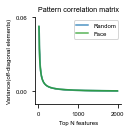

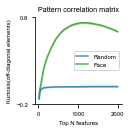

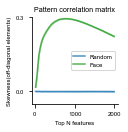

In [59]:
for metric in [#'normal', ,'mean_abs'
               'var','kurt','skew']:
    plot_start()
    for dt_name in ['RD1','FD',]:#,('RD2',RD2_binary_feat_cor)]:
        y = np.array(pattern_r_dt_metric[dt_name][metric]) # seed, N_features_num
        mean = y.mean(1)
        std = y.std(1)
        color = {'FD':'C2','RD1':'C0'}[dt_name]
        label = {'FD':'Face','RD1':'Random'}[dt_name]
        plt.plot(N_feature_list, mean,label=label, color=color, alpha=0.8)
        plt.fill_between(N_feature_list, mean-std,mean+std, color=color,alpha=0.3)
    
    ylabel = {#'normal': 'normality p-value of r distribution', 
         #'mean_abs': 'mean of abs(r) distribution',
         'var': 'Variance',
         'kurt':'Kurtosis',
         'skew':'Skewness',
            }[metric]+'(off-diagonal elements)'
    plt.ylabel(ylabel)
    yrange = { 'var': (-0.01,0.06),
         'kurt':(-0.2,0.8),
         'skew':(-0.05,0.3)}[metric]
    ticks = { 'var': (0.,0.06),
         'kurt':(-0.2,0.8),
         'skew':(0,0.3)}[metric]
    plt.ylim(yrange)
    plt.yticks(ticks)
    plt.title('Pattern correlation matrix')
    plt.xlabel('Top N features')
    plt.legend()
    plt.savefig(f'figures/{metric}_pattern_corr.pdf', bbox_inches="tight")
    plt.show()
    
    

In [11]:
# continuous feature correlation stats
cont_r_dt_metric = {}
N_feature_list = np.arange(10,2000,5)
for total_fea in N_feature_list:
    ind = np.triu_indices(total_fea, k = 1)
    for dt_name, dt in [('FD', FD_cont_feat_cor),('RD1',RD1_cont_feat_cor)]:#,('RD2',RD2_cont_feat_cor)]:
        if dt_name not in cont_r_dt_metric:
            cont_r_dt_metric[dt_name] = {}
        for metric in ['normal', 'var','mean_abs','kurt','skew']:
            f = {'normal': lambda x: normaltest(x)[1], 
                 'var': np.var,
                 'mean_abs': lambda x: np.mean(np.abs(x)),
                
                'kurt':kurtosis,
                 'skew':skew,}[metric]
            if metric not in cont_r_dt_metric[dt_name]:
                cont_r_dt_metric[dt_name][metric] = []
            r_values = dt[ind]
            cont_r_dt_metric[dt_name][metric].append(f(r_values))


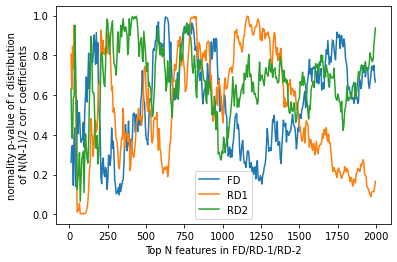

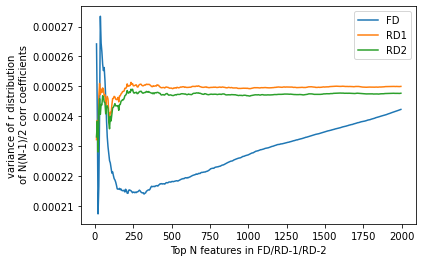

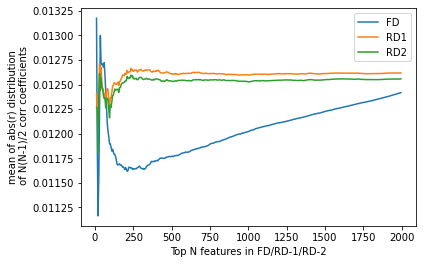

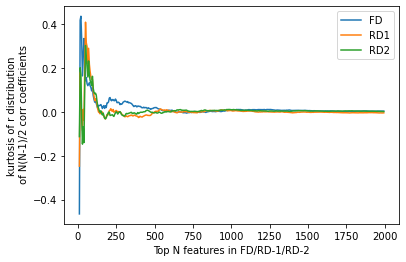

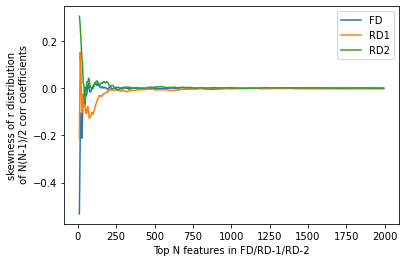

In [12]:
for metric in ['normal', 'var','mean_abs','kurt','skew']:
    plt.figure()
    for dt_name in ['FD','RD1']:#,('RD2',RD2_cont_feat_cor)]:
        ylabel = {#'normal': 'normality p-value of r distribution', 
         #'mean_abs': 'mean of abs(r) distribution',
         'var': 'Variance',
         'kurt':'Kurtosis',
         'skew':'Skewness',
            }[metric]+'(off-diagonal elements)'
        plt.plot(N_feature_list, cont_r_dt_metric[dt_name][metric],label=dt_name)
    plt.ylabel(label)
    plt.xlabel('Top N features in FD/RD-1/RD-2')
    plt.legend()
    plt.show()

In [34]:
# binary feature correlation stats
bin_r_dt_metric = {}
N_feature_list = np.arange(10,2000,5)
for total_fea in N_feature_list:
    ind = np.triu_indices(total_fea, k = 1)
    for dt_name, dt in [('FD', FD_binary_feat_cor),('RD1',RD1_binary_feat_cor)]:#,('RD2',RD2_binary_feat_cor)]:
        if dt_name not in bin_r_dt_metric:
            bin_r_dt_metric[dt_name] = {}
        for metric in ['normal', 'var','mean_abs','kurt','skew']:
            f = {'normal': lambda x: normaltest(x)[1], 
                 'var': np.var,
                 'mean_abs': lambda x: np.mean(np.abs(x)),
                'kurt':kurtosis,
                 'skew':skew,
                }[metric]
            if metric not in bin_r_dt_metric[dt_name]:
                bin_r_dt_metric[dt_name][metric] = []
            bin_r_dt_metric[dt_name][metric].append([f(x[ind]) for x in dt])

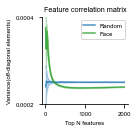

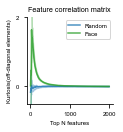

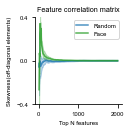

In [51]:
for metric in [#'normal', ,'mean_abs'
               'var','kurt','skew']:
    plot_start()
    for dt_name in ['RD1','FD',]:#,('RD2',RD2_binary_feat_cor)]:
        y = np.array(bin_r_dt_metric[dt_name][metric]) # seed, N_features_num
        mean = y.mean(1)
        std = y.std(1)
        color = {'FD':'C2','RD1':'C0'}[dt_name]
        label = {'FD':'Face','RD1':'Random'}[dt_name]
        plt.plot(N_feature_list, mean,label=label, color=color, alpha=0.8)
        plt.fill_between(N_feature_list, mean-std,mean+std, color=color,alpha=0.3)
    
    ylabel = {#'normal': 'normality p-value of r distribution', 
         #'mean_abs': 'mean of abs(r) distribution',
         'var': 'Variance',
         'kurt':'Kurtosis',
         'skew':'Skewness',
            }[metric]+'(off-diagonal elements)'
    plt.ylabel(ylabel)
    yrange = { 'var': (0.0002,0.0004),
         'kurt':(-0.5,2),
         'skew':(-0.4, 0.4)}[metric]
    ticks = { 'var': (0.0002,0.0004),
         'kurt':(0,2),
         'skew':(-0.4,0, 0.4)}[metric]
    plt.ylim(yrange)
    plt.yticks(ticks)
    plt.title('Feature correlation matrix')
    plt.xlabel('Top N features')
    plt.legend()
    plt.savefig(f'figures/{metric}_feat_corr.pdf', bbox_inches="tight")
    plt.show()